# Lab 5: Regression and Dimensionality Reduction

In this lab, I will follow the given example to implement a `RandomForestRegressor` and `LinearRegressor` to predict the insurance data. 
* For Task 1, I will implement a `SVR` model and compare this to the previous two. 
* For Task 2, I will use `FastICA` and `FeatureAgglomeration` to reduce the dimensionality of the data and repeat the analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, TransformedTargetRegressor)
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.preprocessing import (StandardScaler, RobustScaler, OneHotEncoder,MinMaxScaler,  FunctionTransformer)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn import set_config
from sklearn.decomposition import FastICA 
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import RFE
from sklearn import svm
from sklearn.svm import SVR
from sklearn import manifold 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.cluster import FeatureAgglomeration

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


import warnings
warnings.filterwarnings('ignore')

## EDA

In [2]:
df = pd.read_csv("./insurance.csv")
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [3]:
df.tail()

,age,gender,bmi,children,smoker,region,insurance_cost
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240
1337,64,male,23.760,0,yes,southeast,26926.51440


In [4]:
df['gender'].value_counts()

male      676
female    662
Name: gender, dtype: int64

In [5]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [6]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

In [7]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

There are no missing values. 

In [8]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


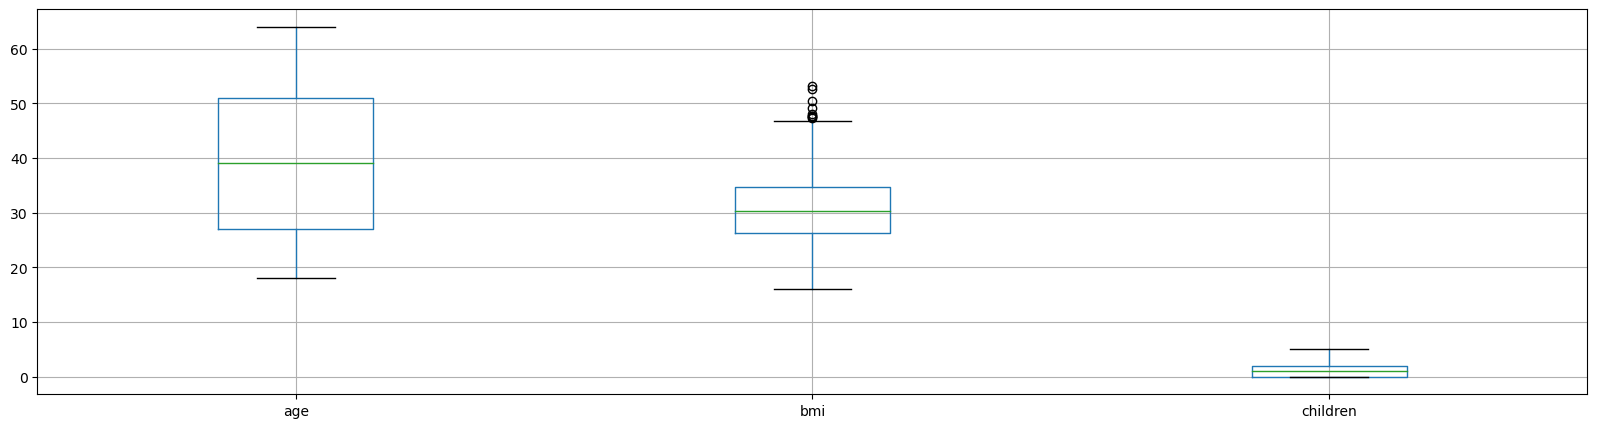

In [9]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20,5))
plt.show()

There are some outliers in the `bmi` column. We will apply RobustScaler to this and StandardScaler to `age` and `children`. Let's also examine the histograms of all attribtes.

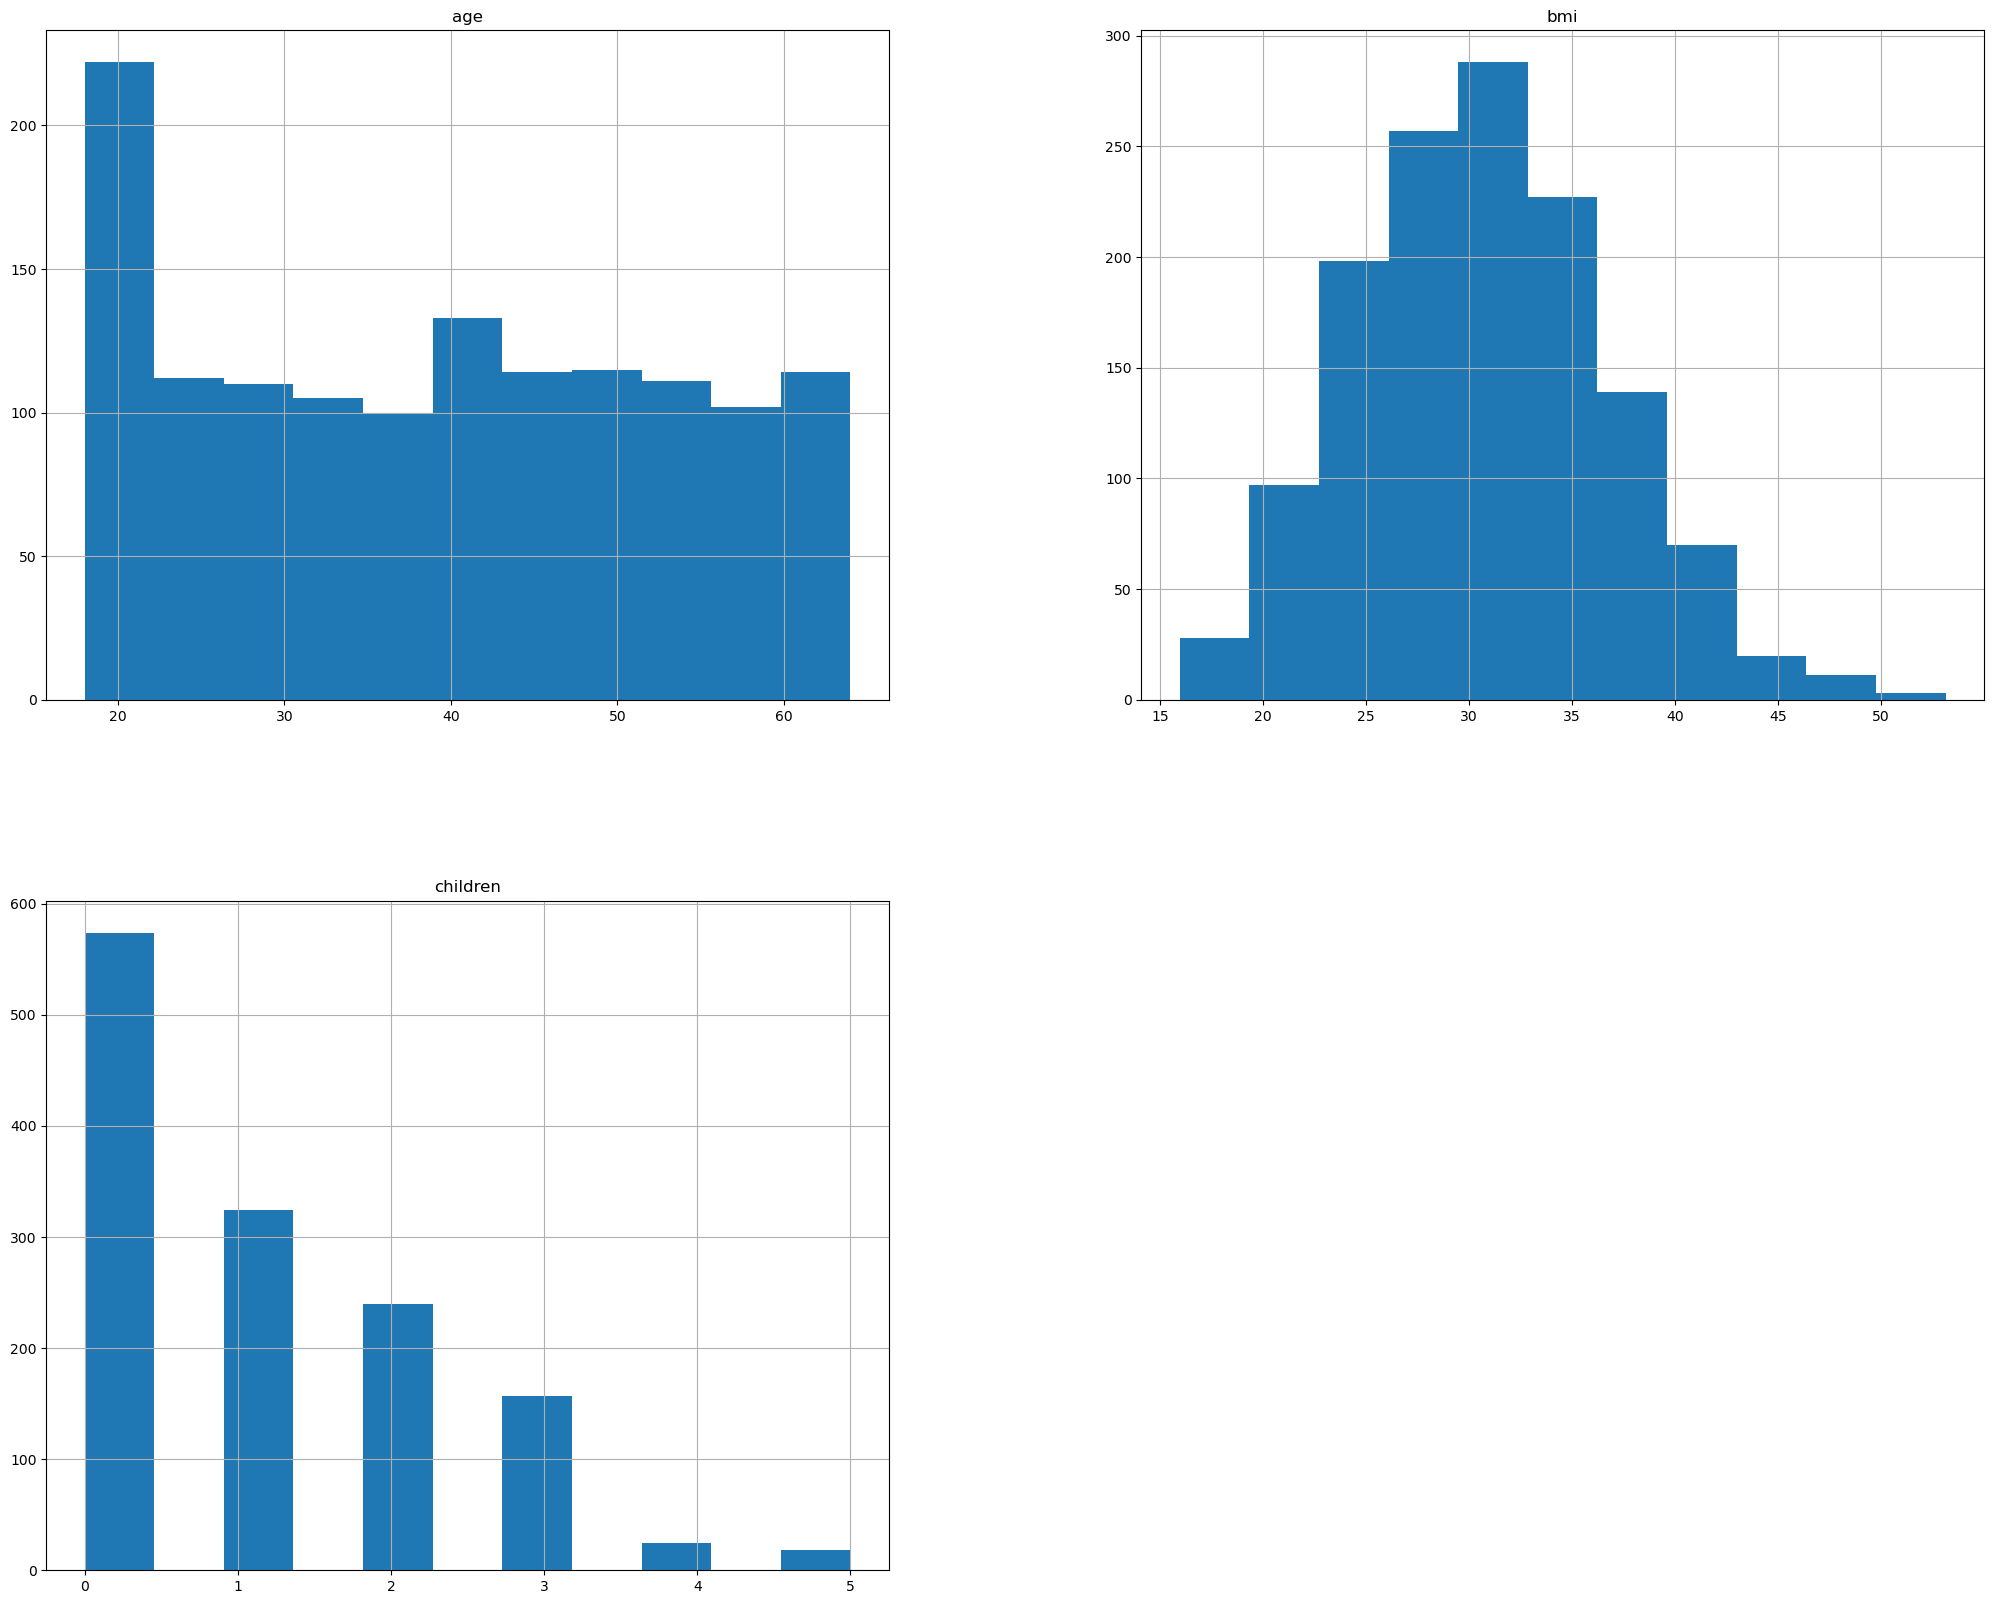

In [10]:
df.drop('insurance_cost', axis=1).hist(bins=11, figsize=(25, 20));

The histograms above show a relatively close-to-normal distribution for `bmi`, this does not require a transformation - we will apply the `Robustscaler` to remove outliers. 
Since `children` is heavily right skewed, and `age` has many values at 18, a log transform may make the situation worse, lets explore these cases below. 

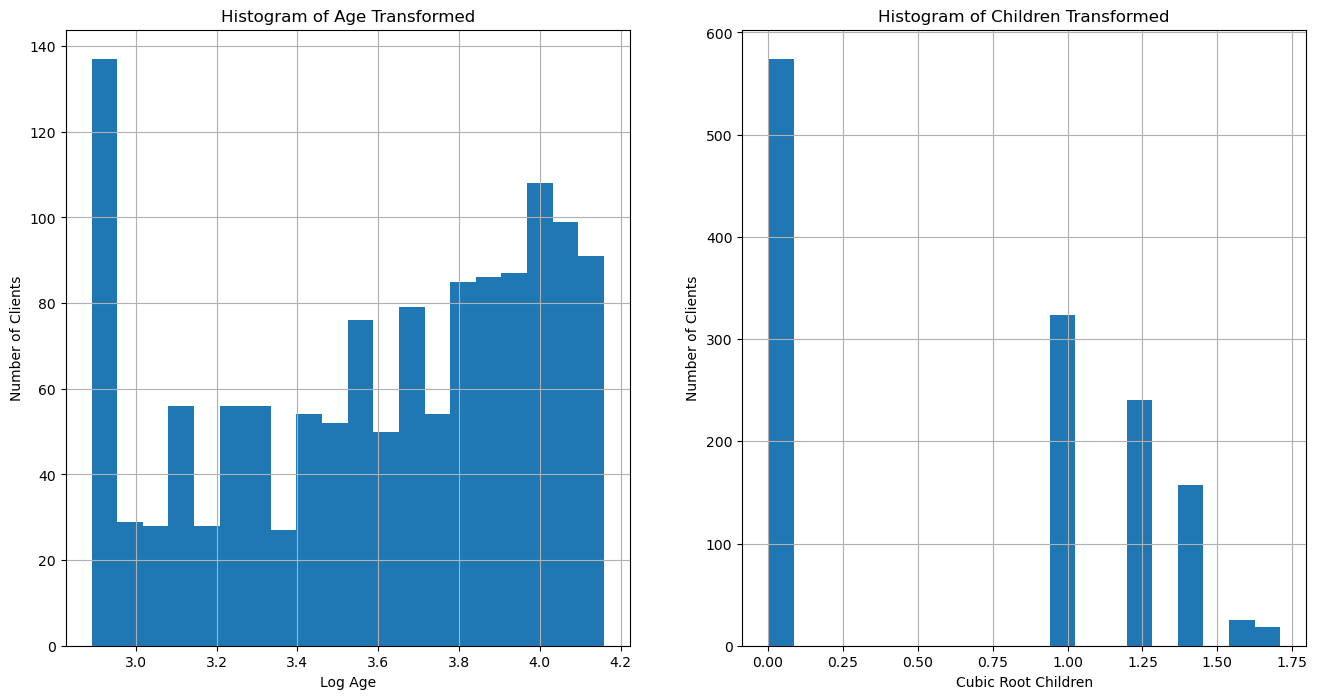

In [11]:
# Create figure with two subplots
fig = plt.figure(figsize=(16,8))
df['age_log'] = np.log(df['age'])
df['cb_children'] = np.cbrt(df['children'])

# Plot age
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title("Histogram of Age Transformed")
ax1.set_xlabel('Log Age')
ax1.set_ylabel('Number of Clients')
(df['age_log']).hist(bins=20)

# Plot age
ax3 = fig.add_subplot(1, 2, 2)
ax3.set_title("Histogram of Children Transformed")
ax3.set_xlabel('Cubic Root Children')
ax3.set_ylabel('Number of Clients')
df['cb_children'].hist(bins=20)

plt.show()

df = df.drop('age_log', axis=1)
df = df.drop('cb_children', axis=1)

We clearly see that the transformations have in fact caused a disimprovement in the ditributoins of the data. Since normality is not nescesarily an assumption for linear regression (the resiuals must be normally distributed). We proceed to scale these variables using a max min scaler instead. 

Since both the children variable is ordinal we will use a minmax scaler ot bring it to a similar scale as the other predictors.
For age, we will use the same. 

Next, let's examine the `insurance_cost` column which is the target of the regression model we are about to train

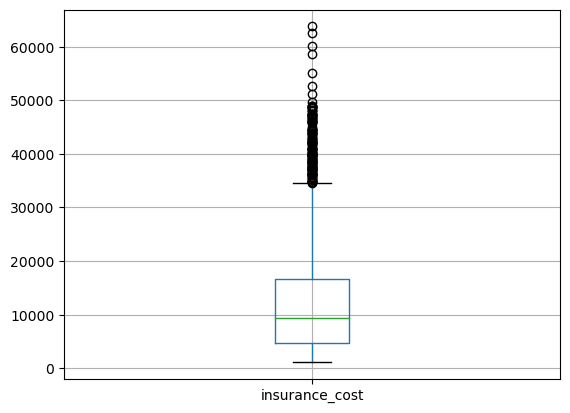

In [12]:
df.boxplot(column=['insurance_cost'])
plt.show()

The outliers above are possible acceptable for certain insurance premiums. 

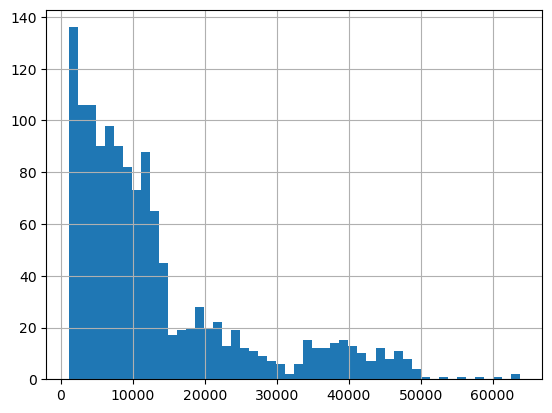

In [13]:
df['insurance_cost'].hist(bins=50)
plt.show()

Depending on the regression model we train, we may want to apply a logarithmic transformation the target variable. i.e. `insurance_cost`.

## Data Preparation

Split the data into target `y` and predictors `X`. 

In [14]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1)

Next, we build a data preprocessing pipeline in which we will apply one-hot encoding to the `gender`, `region`, and `smoker` columns, as well as scalers to the numerical predictors as we discussed above. The transformation of the target will be done later when we build the final pipeline.

In [15]:
preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("no_outliers", StandardScaler(), ['age', 'children']),
        ("categorical", OneHotEncoder(drop='first', sparse_output=False), ['gender', 'region', 'smoker'])
    ],
    remainder=RobustScaler()
).set_output(transform="pandas") 



Let train the preprocessing pipeline on the predictors just to test if it does what we expect it to do.

In [16]:
X_transformed = preprocess_pipeline.fit_transform(X);

In [17]:
X_transformed.describe()

,no_outliers__age,no_outliers__children,categorical__gender_male,categorical__region_northwest,categorical__region_southeast,categorical__region_southwest,categorical__smoker_yes,remainder__bmi
count,1.338000e+03,1.338000e+03,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,-1.699355e-16,-6.372581e-17,0.505232,0.242900,0.272048,0.242900,0.204783,0.031366
std,1.000374e+00,1.000374e+00,0.500160,0.428995,0.445181,0.428995,0.403694,0.726191
min,-1.509965e+00,-9.086137e-01,0.000000,0.000000,0.000000,0.000000,0.000000,-1.719559
25%,-8.691547e-01,-9.086137e-01,0.000000,0.000000,0.000000,0.000000,0.000000,-0.488687
50%,-1.474046e-02,-7.876719e-02,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.396738e-01,7.510793e-01,1.000000,0.000000,1.000000,0.000000,0.000000,0.511313
max,1.765289e+00,3.240619e+00,1.000000,1.000000,1.000000,1.000000,1.000000,2.706758


In [18]:
X_transformed.tail()

,no_outliers__age,no_outliers__children,categorical__gender_male,categorical__region_northwest,categorical__region_southeast,categorical__region_southwest,categorical__smoker_yes,remainder__bmi
1333,1.765289,0.751079,0.0,0.0,0.0,0.0,0.0,0.169693
1334,1.765289,-0.908614,0.0,1.0,0.0,0.0,1.0,-0.418577
1335,1.765289,-0.908614,1.0,0.0,0.0,0.0,0.0,-0.475141
1336,1.765289,0.751079,1.0,0.0,1.0,0.0,1.0,0.781185
1337,1.765289,-0.908614,1.0,0.0,1.0,0.0,1.0,-0.790712


Now, let's split the original dataset into a training and test datasets.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

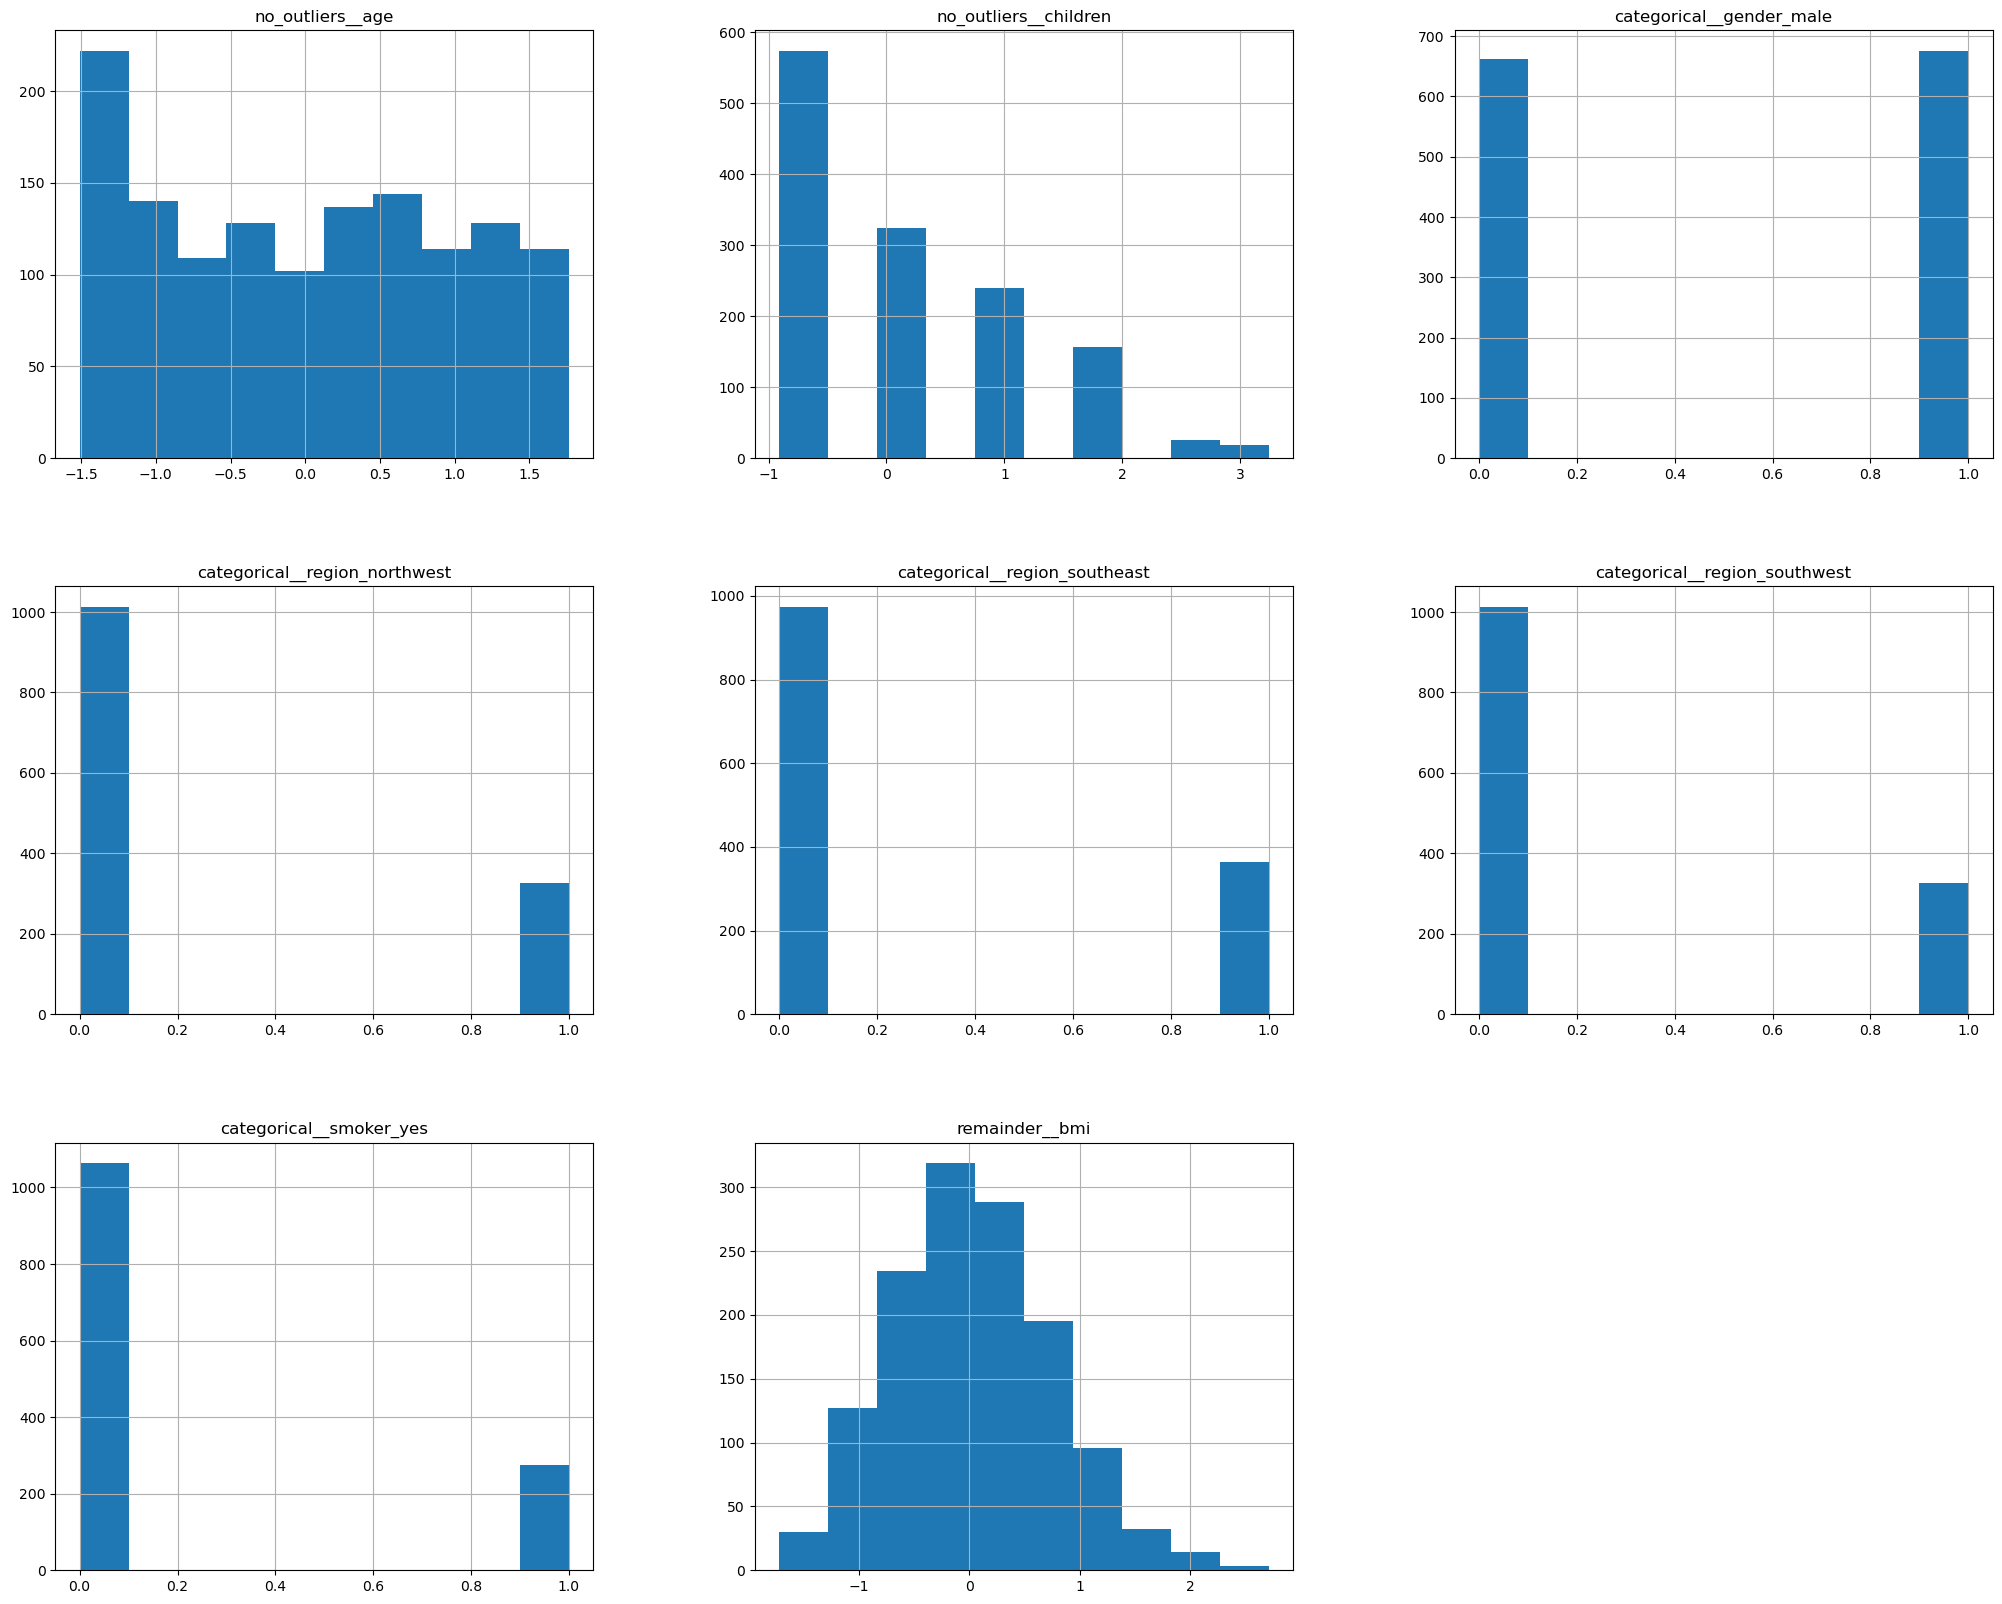

In [20]:
X_transformed.hist(bins=10, figsize=(25, 20));

We observe the transformed trianing set above. The dummy variables are apparently discrete, while bmi variable is now normally distributed. Age and children are scaled correctly.  

## Grid Search for Best Parameters and Best Dimensionality Reduction Method

For all parameter grids, we explore a selection of paramers. Note, results may differ based on notebook version. 

### Random Forest Pipeline

A pipeline for dimensionality reduction, the param_grid will choose the best of three. 

In [21]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=RandomForestRegressor(n_estimators=10),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

A selection of parameter values for the `RandomForestRegressor` are chosen for the param_grid to find the best combination of. 

In [22]:
N_FEATURES_OPTIONS = [2, 5, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.854:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'ttr__regressor__max_depth': 4}


### Linear Regression Pipeline

In [23]:
pipe_regression = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=LinearRegression(),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

In [24]:
N_FEATURES_OPTIONS = [2, 6, 11]
FIT_INTERCEPT_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    }  
]

search = GridSearchCV(pipe_regression, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.521:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'ttr__regressor__fit_intercept': True}


So far, the random forest has a higher CV score and appears to be the better model. We will verify this with test data .

## Compare Regression Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

to choose the better regressor for our problem.

In [25]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

In [26]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)

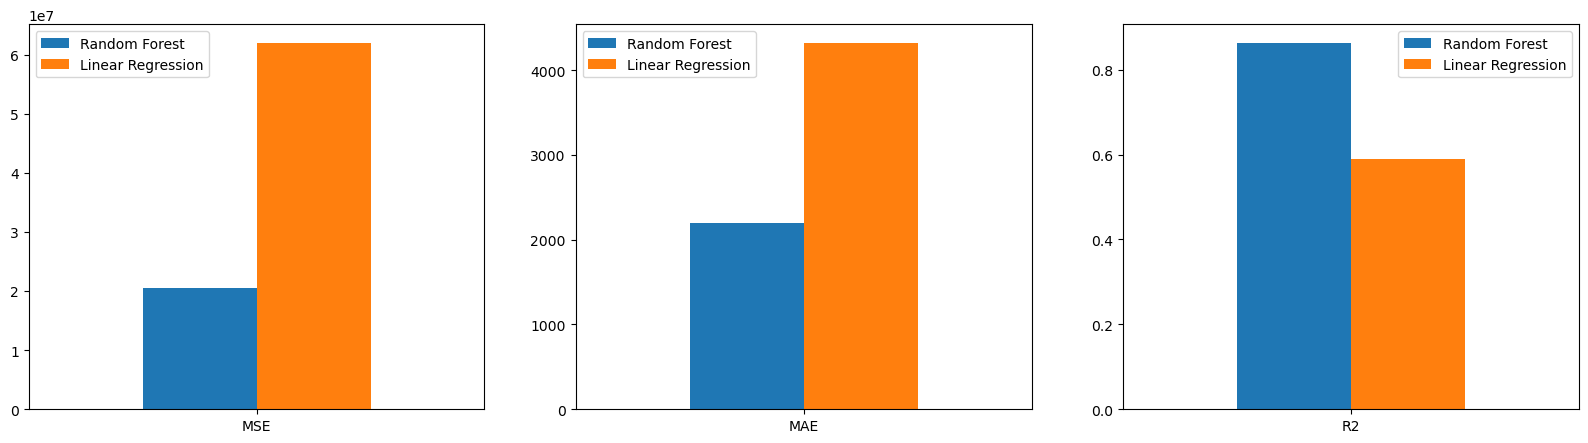

In [27]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

The plots confirm that the RandomForest is better at modelling the data, since it has a lower MSE, MAE, and a higher coefficient of determination (R2).

## Adding SVM (TASK 2)

### SVM Pipeline

In [28]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=SVR(),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

Again, a selection of parameter values for the SVM regressor are chosen for the parameter grid. 

In [41]:
C_OPTIONS =  [0.1, 1, 10]
GAMMA_OPTIONS =  [1, 0.1, 0.01]
N_FEATURES_OPTIONS = [2, 5, 6, 11]

param_grid = [
            {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__C': C_OPTIONS,  
        'ttr__regressor__gamma': GAMMA_OPTIONS    
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
               'ttr__regressor__C': C_OPTIONS,  
        'ttr__regressor__gamma': GAMMA_OPTIONS
        
    },
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVR_best_params = search.best_params_
SVR_best_model = search.best_estimator_

Best CV score = 0.825:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=11), 'reduce_dim__n_features_to_select': 11, 'ttr__regressor__C': 10, 'ttr__regressor__gamma': 0.1}


In [42]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
SVR_mse, SVR_mae, SVR_r2 = evaluate_model(X_test, y_test, SVR_best_model)

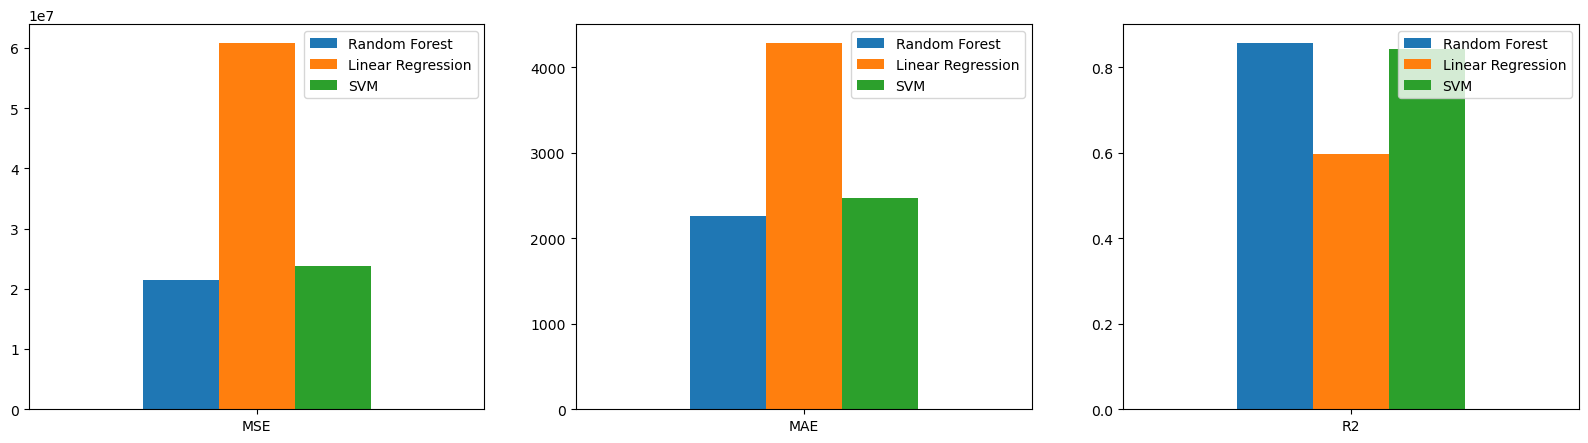

In [43]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'SVM': SVR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'SVM':SVR_mae }, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'SVM': SVR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

* The best `RandomForest Regression` model has a depth of 4, using the `RFE` with 11 features for dimensionality reduction. 
* The best `Linear Regression` model has a fitted intercept, using the `RFE` with 6 features for dimensionality reduction. 
* The best `SV Regression` model has C = 10 and gamma = 0.1, using the `RFE` with 11 features for dimensionality reduction. 

Observing the plots:
* The random forest model is clearly the best of the three here. It has the lowest RMSE, and MAE. And the highest R2. This means it explains over 80% in the response compared to the other models, and it has the lowest median absolute prediction error of 2,000 units (prediction - actual).  

* The Linear regression is the worst performing model across all metrics. It only explains 60% of the variation in the response, and has median absolute error of over 4000 units.  
* The SVM performs second best. It performs very similar to the random forest, with an R2 of 0.8.



200 words. 

## Adding Dimensionality Reduction (TASK 3)

In [32]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=RandomForestRegressor(n_estimators=10),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

### Random Forest Pipeline

In [33]:
N_FEATURES_OPTIONS = [2, 3, 5, 6, 7, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
LINKAGE_OPTIONS = ['ward', 'complete','average','single']

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), FastICA(whiten = 'unit-variance', max_iter = 1000)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [FeatureAgglomeration()],
        'reduce_dim__n_clusters': N_FEATURES_OPTIONS,
        'reduce_dim__linkage': LINKAGE_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    }
    
]


search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.854:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=8), 'reduce_dim__n_features_to_select': 8, 'ttr__regressor__max_depth': 4}


### Linear Regression Pipeline

In [34]:
pipe_regression = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=LinearRegression(),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

In [36]:
N_FEATURES_OPTIONS = [2, 3, 5, 6, 7, 8]
FIT_INTERCEPT_OPTIONS = [False, True]
LINKAGE_OPTIONS = ['ward', 'complete','average','single']

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), FastICA(max_iter = 4000, whiten = 'unit-variance')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    },
        {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    },
        {
        'reduce_dim': [FeatureAgglomeration()],
        'reduce_dim__n_clusters': N_FEATURES_OPTIONS,
        'reduce_dim__linkage': LINKAGE_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    }
    
]

search = GridSearchCV(pipe_regression, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.521:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear'), n_features_to_select=5), 'reduce_dim__n_features_to_select': 5, 'ttr__regressor__fit_intercept': True}


### SVM Pipeline

In [37]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=SVR(),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

In [50]:
C_OPTIONS =  [0.1, 1, 10]
GAMMA_OPTIONS =  [1, 0.1, 0.01]
N_FEATURES_OPTIONS = [2,4, 6, 7, 8]
LINKAGE_OPTIONS = ['ward', 'complete','average','single']

param_grid = [
            {
        'reduce_dim': [PCA(iterated_power=7), FastICA(tol=0.1, whiten = 'unit-variance')],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__C': C_OPTIONS,  
        'ttr__regressor__gamma': GAMMA_OPTIONS
    },
        {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
               'ttr__regressor__C': C_OPTIONS,  
        'ttr__regressor__gamma': GAMMA_OPTIONS
    },
        {
        'reduce_dim': [FeatureAgglomeration()],
        'reduce_dim__n_clusters': N_FEATURES_OPTIONS,
        'reduce_dim__linkage': LINKAGE_OPTIONS,
        'ttr__regressor__C': C_OPTIONS,  
        'ttr__regressor__gamma': GAMMA_OPTIONS
        }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #training happens here! SVM is trained 48x5 = 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVR_best_params = search.best_params_
SVR_best_model = search.best_estimator_

Best CV score = 0.825:
Best parameters:  {'reduce_dim': PCA(iterated_power=7, n_components=8), 'reduce_dim__n_components': 8, 'ttr__regressor__C': 10, 'ttr__regressor__gamma': 0.1}


In [51]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
SVR_mse, SVR_mae, SVR_r2 = evaluate_model(X_test, y_test, SVR_best_model)

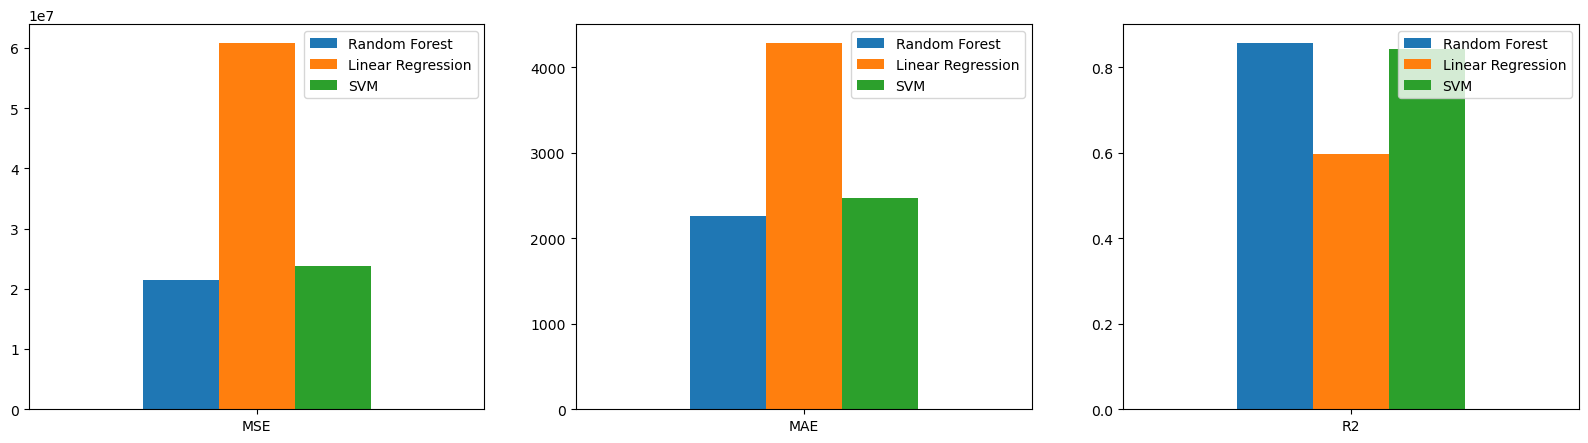

In [52]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'SVM': SVR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'SVM':SVR_mae }, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'SVM': SVR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

* The best `RandomForest Regression` model has a max depth of 8 (same as before), this still uses using `RFE` with 3 less features than before. 
* The best `Linear Regression` model has a fitted intercept, and uses RFE with 5 componenets. 
* The best `SV Regression` model has not changed from before. The PCA is chosen as the best dimensionality reduction method with 8 components. This is an increase from the 5 components with the `RFE` method. 
 

The Random Forest Regressor has remains the best, with an R2 of approx. 80%, MAE of 2000. 
The SVM remains to have an R2 of approx 80% and error values slightly higher than the random forest regression. It appears Using PCA for the SVM does not differ from using RFE. 
The linear regression model has not changed in accuracy from before even though it tested the PCA dimensionality reduction method. 

160 words. 